In [1]:
import torch, pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from numpy.polynomial.polynomial import Polynomial
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
maxdist = 50
pi = 3.141_592_653_589
bpm = nfft/maxdist

def centroid(self, dim=0):
    return ((torch.arange(self.shape[dim], device=self.device) * self.transpose(-1,dim)).sum(-1) / self.sum(dim)).transpose(-1,dim)
torch.Tensor.centroid = centroid

print(f'resolution: 1 bin = {1e6*maxdist/nfft:.2f}µm')

cuda:0
resolution: 1 bin = 190.73µm


## Peak Location

| A/02 | 10° | 2.141m | 5° | 2.138m | 0° | 2.140m | -5° | 2.138m | -10° | 2.138m |
| A/08 | -10° | 8.097m | -5° | 8.097m | 0° | 8.099m | 5° | 8.099m | 10° | 8.097m |
| A/18 | 10° | 18.016m | 5° | 18.018m | 0° | 18.016m | -5° | 18.015m | -10° | 18.017m |
| A/32 | -10° | 32.286m | -5° | 32.284m | 0° | 32.284m | 5° | 32.287m | 10° | 32.285m |


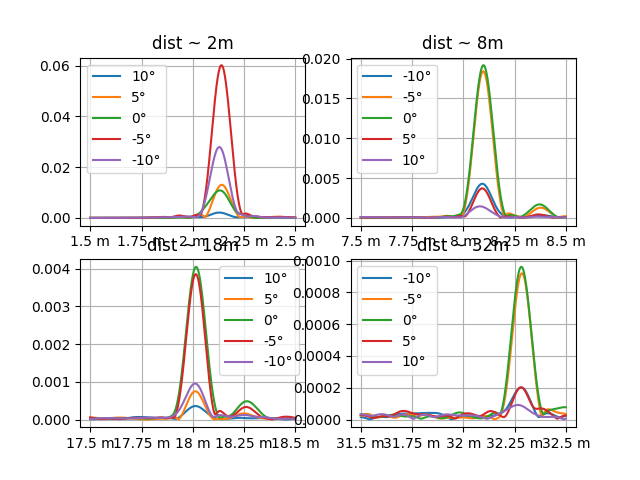

In [2]:
%matplotlib widget
fig, axes = plt.subplots(2,2)
for ax,dist in zip(axes.flat, (2,8,18,32)):
    fft = torch.load(f'{folder}a{dist:02d}_bp_fft.pt')
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)  
    print(f'| A/{dist:02d} |', end='')
    M,K,L = fft.shape
    angle_deg = [a*180/pi - 90 for a in angle]
    sel_angle = [l for l,a in enumerate(angle_deg) if -10<a<10]
    sel_angle = sel_angle[::len(sel_angle)//4] + [sel_angle[-1]]

    ranges = [m/bpm+dist-0.5 for m in range(M)]
    for l in sel_angle:
        ax.plot(ranges, fft[:,:,l].mean(1).abs(), label=f'{round(angle_deg[l])}°')
        print(f' {round(angle_deg[l])}° | {(fft[:,:,l].abs().mean(1).argmax()/bpm + dist - 0.5):.3f}m |', end='')
    print('')
    ax.xaxis.set_major_formatter(EngFormatter('m'))
    ax.grid()
    ax.legend()
    ax.set_title(f'dist ~ {dist}m')
    #print(f'computed plots for measurement A/{dist:02d}')
    fft = None


| Measurement | Angle | Distance | Angle | Distance | Angle | Distance | Angle | Distance | Angle | Distance |
|:------------|------:|---------:|------:|---------:|------:|---------:|------:|---------:|------:|---------:|
| A/02 | 10° | 2.141m | 5° | 2.138m | 0° | 2.140m | -5° | 2.138m | -10° | 2.138m |
| A/08 | -10° | 8.097m | -5° | 8.097m | 0° | 8.099m | 5° | 8.099m | 10° | 8.097m |
| A/18 | 10° | 18.016m | 5° | 18.018m | 0° | 18.016m | -5° | 18.015m | -10° | 18.017m |
| A/32 | -10° | 32.286m | -5° | 32.284m | 0° | 32.284m | 5° | 32.287m | 10° | 32.285m |

## Rotation Angle Offset

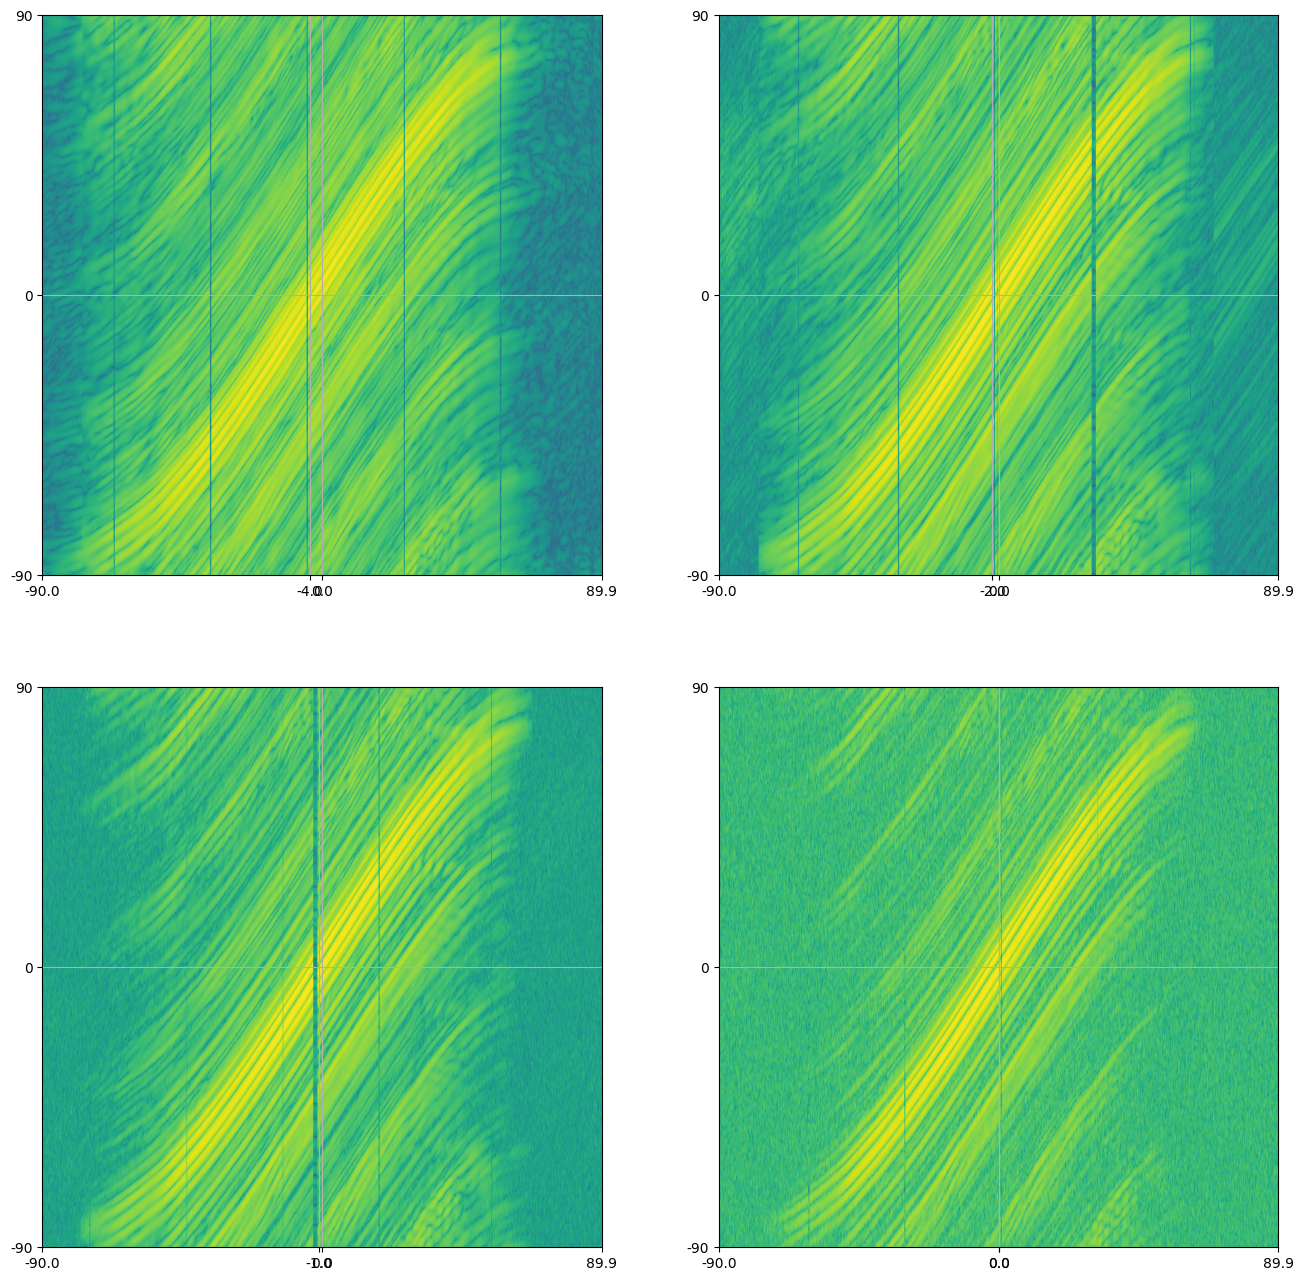

In [23]:
%matplotlib inline
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']
vx,vy = params['vxPosX'], params['vxPosY']
ula = [[x if y==0 else -10 for x,y in zip(vx,vy)].index(v) for v in sorted(set(vx))]

fig, axes = plt.subplots(2,2)
for ax,dist,offs in zip(axes.flat, (2,8,18,32), (-4,-2,-1,0)):
    # with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
    #     angle = pickle.load(f)  
    # angle_deg = [round(a*180/pi - 90, 1) for a in angle]
    # l_deg = [angle_deg.index(a/10) if a/10 in angle_deg else -1 for a in  range(-900,900,1)]
    # angle_deg = [0.1*a for a in range(-900,900,1)]
    # fft=None
    # fft = torch.load(f'{folder}a{dist:02d}_bp_fft.pt')[:,:,l_deg]

    # torch.save(fft,f'{folder}a{dist:02d}_bp_fft_wholedeg.pt')
    # pickle.dump(list(sorted(set((angle_deg)))), open(f'{folder}a{dist:02d}_angle_deg.pt', 'wb'))
            
    angle_deg = pickle.load(open(f'{folder}a{dist:02d}_angle_deg.pt', 'rb'))
    fft = torch.load(f'{folder}a{dist:02d}_bp_fft_wholedeg.pt')

    M,K,L = fft.shape
    m_refl = fft.abs().mean(1).argmax(0)
    fft = fft[m_refl,:,range(L)]
    N_azm = 1801
    azm = torch.fft.fftshift(torch.fft.fft(fft[:,ula],dim=1,n=N_azm), dim=1)
    img = 20*azm.abs().log10() - 20*azm.abs().log10().max()
    ax.imshow(img.T, origin='lower')
    ax.set_yticks((0,900,1800),(-90,0,90))
    ax.set_xticks((0,900+10*offs, 900,L-1), [angle_deg[l] for l in (0,900+10*offs,900,L-1)])
    ax.grid()
fig.set_size_inches(16,16)

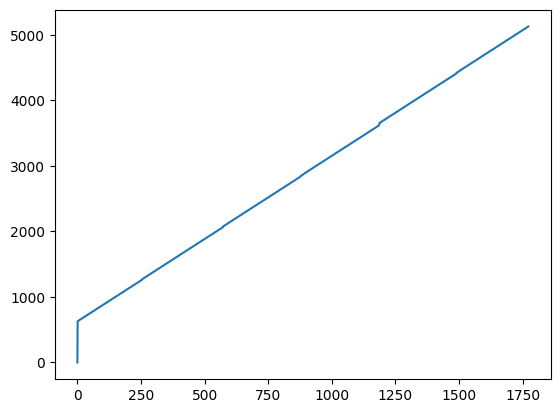

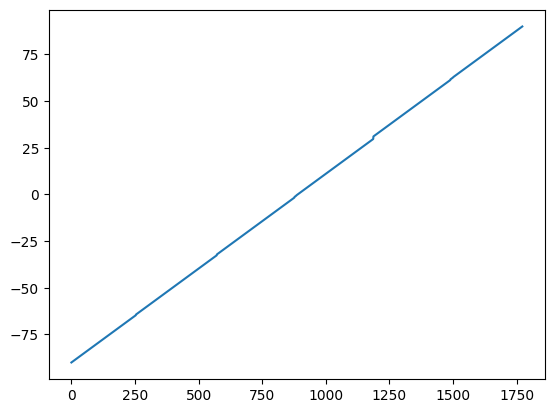

In [14]:
%matplotlib inline
with open(f'{folder}a08_angle.pkl', 'rb') as f:
    angle = pickle.load(f)  
angle_deg = [round(a*180/pi - 90,1) for a in angle]
l_deg = [angle_deg.index(a) for a in sorted(set(angle_deg))]
angle_deg = list(sorted(set(angle_deg)))
plt.plot(l_deg)
plt.show()
plt.plot(angle_deg)
plt.show()

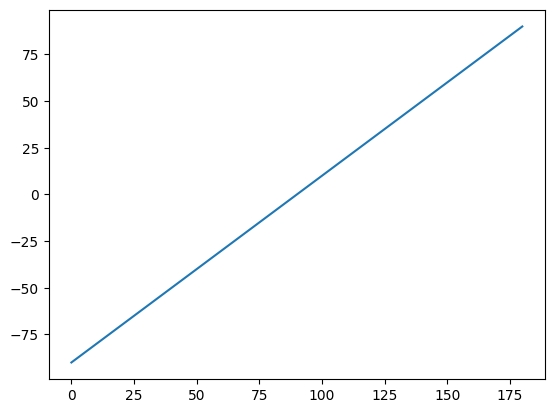

In [26]:
%matplotlib inline
plt.plot(angle_deg)

torch.Size([5242, 180, 181])


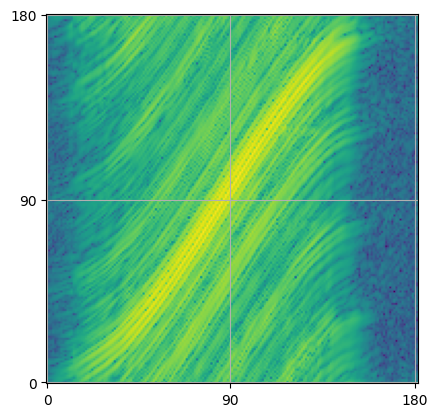

In [32]:
N_azm = 180
#azm = torch.fft.fftshift(torch.fft.fft(fft[:,ula,:]/fft[m_refl[90],:,90, None],dim=1,n=N_azm), dim=1)
azm = torch.fft.fftshift(torch.fft.fft(fft[:,ula,:],dim=1,n=N_azm), dim=1)
print(azm.shape)
img = azm[m_refl,:,range(L)].abs()
img = 20*img.log10() - 20*img.log10().max()
plt.imshow(img.T, origin='lower')
plt.xticks((0,89,179),(0,90,180))
plt.yticks((0,89,179),(0,90,180))
plt.grid()
plt.show()


| Measurement | Offset   | RMSE       |
|:------------|---------| ----------|
| A/02        | $-0.50°$ | $32.47$ mm  |
| A/08        | $+3.92°$ | $40.12$ mm  |
| A/18        | $-5.99°$ | $38.11$ mm  |
| A/32        | $-50.00°$| $55.56$ mm  | 

## Rotation Excentricity

In [6]:
angle = pickle.load(open(folder + 'a02_angle.pkl', 'rb'))


Measurement A/02...Done.
Measurement A/08...Done.
Measurement A/18...Done.
Measurement A/32...Done.


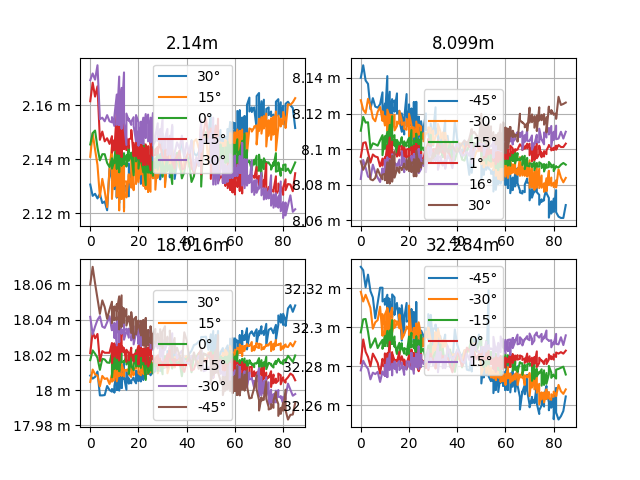

In [7]:
%matplotlib widget
fig, axes = plt.subplots(2,2)
for ax, centroid, sel_angle, actdist in zip(axes.flat, centroids, sel_angles, actual_distances):
    for angle, data in zip(sel_angle, centroid):
        ax.plot(sorted_idx.values(), data[list(sorted_idx.keys())], label=f'{round(angle)}°')
    ax.yaxis.set_major_formatter(EngFormatter('m'))
    ax.legend()
    ax.grid()
    ax.set_title(f'{actdist}m')


In [8]:
exit()
imgs = []
smoothpeak = lambda x, l, N=25 : x[:,:,l:min(x.shape[-1], l+N)].abs().float().mean(-1).argmax(0)

for dist in [2, 8, 18, 32]:
    print(f'Measurement A/{dist:02d}...', end='')
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)  
    angle_deg = [180/pi*a - 90 for a in angle]
    angle_int_idx = []
    l = 0
    angle_int = list(map(round, angle_deg))
    for k in range(-45,45):
        if angle_deg[0] < angle_deg[-1]:
            while angle_deg[l] < k and l < len(angle_deg):
                l += 1
        else:
            l=-1
            while angle_deg[l] < k and -l < len(angle_deg):
                l -= 1
        angle_int_idx.append(l)
    fft = torch.load(f'{folder}a{dist:02d}_bp_fft.pt')
    imgs.append(torch.stack([smoothpeak(fft,l) for l in angle_int_idx], -1))
    fft=None
    print('Done.')

with open(folder + 'a-peak-idx.pkl', 'wb') as f:
    pickle.dump(imgs,f)

Measurement A/02...Done.
Measurement A/08...Done.
Measurement A/18...Done.
Measurement A/32...Done.


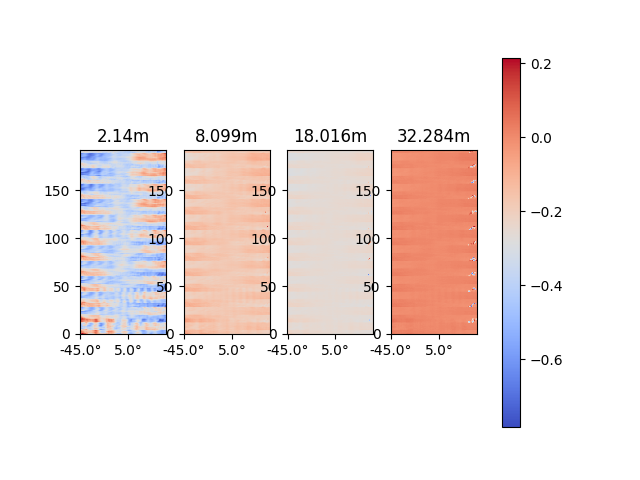

In [9]:
from matplotlib.ticker import FuncFormatter
%matplotlib widget
fig,axes = plt.subplots(1,4)
for dist, img, ax in zip([2.140, 8.099, 18.016, 32.284], imgs, axes.flat):
    im = ax.imshow(img/bpm - 0.5 -dist%1, origin='lower', cmap='coolwarm')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x-45}°'))
    ax.set_title(f'{dist}m')
fig.colorbar(im, ax=list(axes.flat))


In [10]:
ideal = []
with open(folder+'feparams.pkl', 'rb') as f:
    params = pickle.load(f)
xtx, ytx, xrx, yrx = params['txPosX'],params['txPosY'],params['rxPosX'],params['rxPosY']

from math import cos, sin
l2norm = lambda r1,r2 : sum([abs(a-b)**2 for a,b in zip(r1,r2)])**0.5
estimate = lambda k, theta, R, dR :  0.5*l2norm([xtx[k], ytx[k], -dR], [(R-dR)*cos(theta), 0, (R-dR)*sin(theta)])\
                                   + 0.5*l2norm([xrx[k], yrx[k], -dR], [(R-dR)*cos(theta), 0, (R-dR)*sin(theta)])

for excentricity in [-0.1, -0.005, -0.007, 0.05]:
    for dist in [2.140, 8.099, 18.016, 32.284]:
        with open(f'{folder}a{int(dist):02d}_angle.pkl', 'rb') as f:
            angle = pickle.load(f)  
        angle_deg = [180/pi*a - 90 for a in angle]
        angle_int_idx = []
        l = 0
        angle_int = list(map(round, angle_deg))
        for k in range(-45,45):
            if angle_deg[0] < angle_deg[-1]:
                while angle_deg[l] < k and l < len(angle_deg):
                    l += 1
            else:
                l=-1
                while angle_deg[l] < k and -l < len(angle_deg):
                    l -= 1
            angle_int_idx.append(l)
        ideal.append(torch.tensor([[estimate(k,angle[l]-pi/2, dist, excentricity) for l in angle_int_idx] for k in range(len(xtx))]))
        fft=None


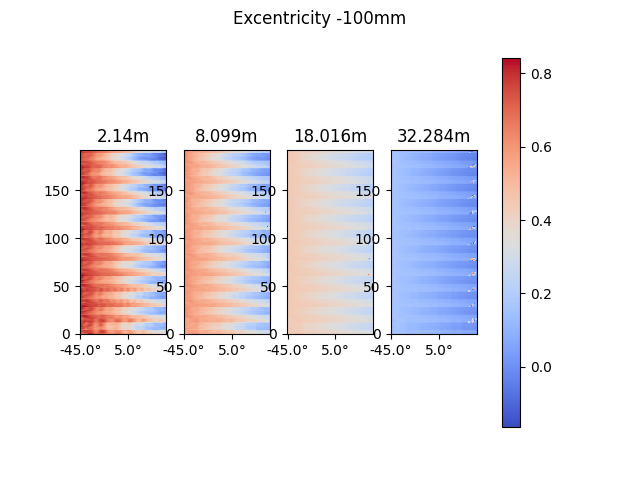

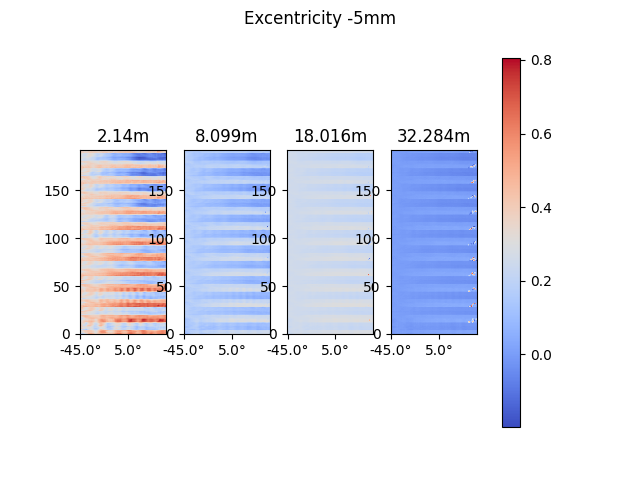

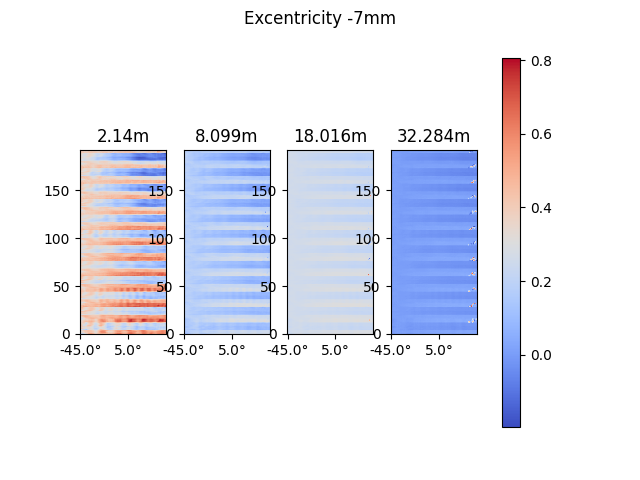

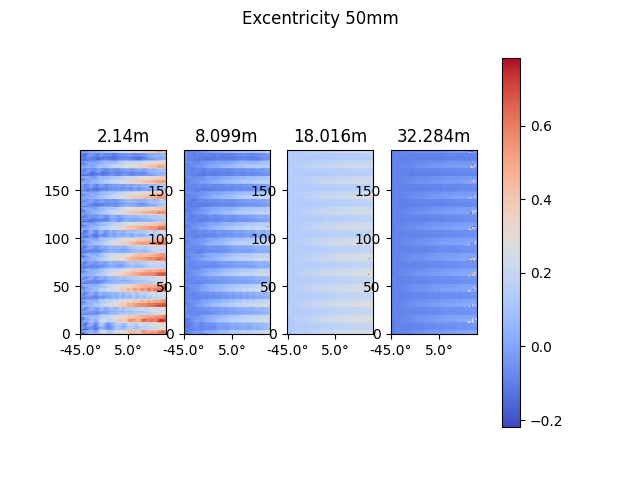

In [11]:
index = 0
for excentricity in [-0.1, -0.005, -0.007, 0.05]:
    fig, axes = plt.subplots(1,4)
    fig.suptitle(f'Excentricity {1000*excentricity:.0f}mm')
    for dist, ax, img in zip([2.140, 8.099, 18.016, 32.284], axes.flat, imgs):
        im = ax.imshow((ideal[index] - (img/bpm-0.5 + int(dist))), origin='lower', cmap='coolwarm')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x-45}°'))
        ax.set_title(f'{dist}m')
        index += 1
    fig.colorbar(im, ax=list(axes.flat))


/tmp/ipykernel_69426/379387169.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2,2, sharex=True, sharey=True)


2.14
8.099
18.016
32.284


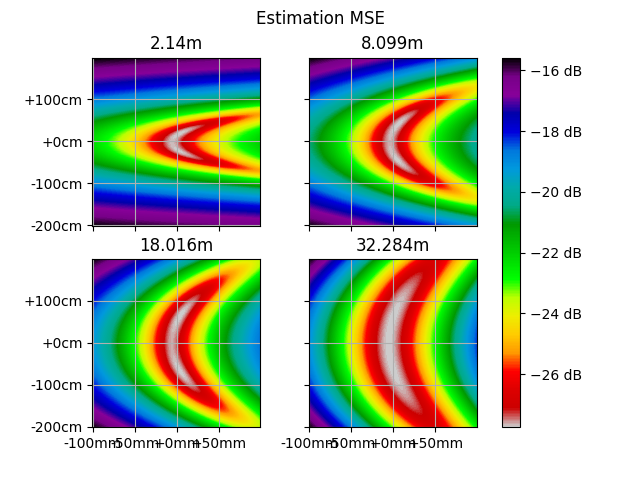

In [31]:
from matplotlib.ticker import FuncFormatter
from math import cos,sin
with open(folder+'feparams.pkl', 'rb') as f:
    params = pickle.load(f)
xtx, ytx, xrx, yrx = params['txPosX'],params['txPosY'],params['rxPosX'],params['rxPosY']

with open(folder+'a-peak-idx.pkl', 'rb') as f:
    imgs = pickle.load(f)

excentricities = torch.arange(-0.1, 0.1, 1e-3)
reflheights = torch.arange(-2, 2, 2e-2)
K, E, H = len(xtx), len(excentricities), len(reflheights)
txpos = torch.tensor([xtx,ytx,[1]*K]).unsqueeze(-1) * torch.tensor([[1]*E, [1]*E, -excentricities]).unsqueeze(1)
rxpos = torch.tensor([xrx,yrx,[1]*K]).unsqueeze(-1) * torch.tensor([[1]*E, [1]*E, -excentricities]).unsqueeze(1)

l2norm = lambda a,b: torch.sqrt(torch.sum((a-b)**2,dim=0))

plt.close(fig)
%matplotlib widget
fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
for dist,img,ax in zip([2.140, 8.099, 18.016, 32.284], imgs, axes.flat):
    print(dist)
    with open(f'{folder}a{int(dist):02d}_angle.pkl', 'rb') as f:
            angle = pickle.load(f)  
    angle_deg = [180/pi*a - 90 for a in angle]
    angle_int_idx = []
    l = 0
    angle_int = list(map(round, angle_deg))
    for k in range(-45,45):
        if angle_deg[0] < angle_deg[-1]:
            while angle_deg[l] < k and l < len(angle_deg):
                l += 1
        else:
            l=-1
            while angle_deg[l] < k and -l < len(angle_deg):
                l -= 1
        angle_int_idx.append(l)
    reflpos = (dist-excentricities) * torch.tensor([[cos(angle[l]-pi/2),0,sin(angle[l]-pi/2)] for l in angle_int_idx]).T.unsqueeze(-1)
    reflpos = reflpos.unsqueeze(-2) + torch.tensor([[0]*H, reflheights, [0]*H]).unsqueeze(-1).unsqueeze(1)
    reflpos = reflpos.unsqueeze(1)
    estimates = l2norm(txpos.unsqueeze(-2).unsqueeze(-2), reflpos)/2 
    estimates += l2norm(txpos.unsqueeze(-2).unsqueeze(-2), reflpos)/2
    img_m = img/bpm-0.5 + round(dist)
    img_m = img_m.unsqueeze(-1).unsqueeze(-1)
    im=ax.imshow(10*(estimates-img_m).square().mean((0,1)).log10(), cmap='nipy_spectral_r', origin='lower')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x-100:+.0f}mm'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*2-200:+.0f}cm'))
    ax.set_title(f'{dist}m')
    ax.grid()
fig.suptitle('Estimation MSE')
cb = fig.colorbar(im, ax=list(axes.flat))
cb.ax.yaxis.set_major_formatter(EngFormatter('dB'))

## Results

| Measurement | Distance  | Angle Offset | Excentricity  |
| ------------|-----------|--------------|---------------|
| A/02        | $ 2.140$ m| $\pm 0°$     | $-5$ mm       |
| A/08        | $ 8.099$ m| $\pm 0°$     | $-5$ mm       |
| A/18        | $18.016$ m| $\pm 0°$     | $-5$ mm       |
| A/32        | $32.284$ m| $\pm 0°$     | $-5$ mm       |

Estimation MSE: -27dB = -30+3dB = 1e-3 * 2 ~= 4.4cm 